<a href="https://colab.research.google.com/github/gowtham66866/Inkers/blob/master/gradCAM_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# ls
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


Loading saved models **with cutout** and **with out cutout**.

In [0]:
from keras.models import load_model
model_with_cutout = load_model('/content/gdrive/My Drive/epochs_059-val_acc_0.869.hdf5')
model_without_cutout = load_model('/content/gdrive/My Drive/epochs_028-val_acc_0.854.hdf5')

**Summary of the models.**

In [8]:
print(model_with_cutout.summary())
print(model_without_cutout.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
__________

In [10]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

print(np.shape(test_features))

four_samples = test_features[:4]
print(np.shape(four_samples))

(10000, 32, 32, 3)
(4, 32, 32, 3)


### Grad CAM with cutout.


In [0]:

%matplotlib inline

def grad_CAM_cutout(img):
    img = img.astype('float32')
    img /= 255
    x = np.expand_dims(img, axis=0)
    
#     x = preprocess_input(x)


    preds = model_with_cutout.predict(x)  #model
#     print("cutout")
    class_idx = np.argmax(preds[0])
    class_output = model_with_cutout.output[:, class_idx]  #moel
    last_conv_layer = model_with_cutout.get_layer("conv2d_14")   # model



    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model_with_cutout.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img_cutout = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return superimposed_img_cutout, preds

### grad CAM without cutout

In [0]:

%matplotlib inline

def grad_CAM(img):
    img = img.astype('float32')
    img /= 255
    x = np.expand_dims(img, axis=0)
#     x = preprocess_input(x)


    preds = model_without_cutout.predict(x)  #model
#     print("no cutout")
    class_idx = np.argmax(preds[0])
    class_output = model_without_cutout.output[:, class_idx]  #moel
    last_conv_layer = model_without_cutout.get_layer("conv2d_62")   # model



    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model_without_cutout.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return superimposed_img, preds

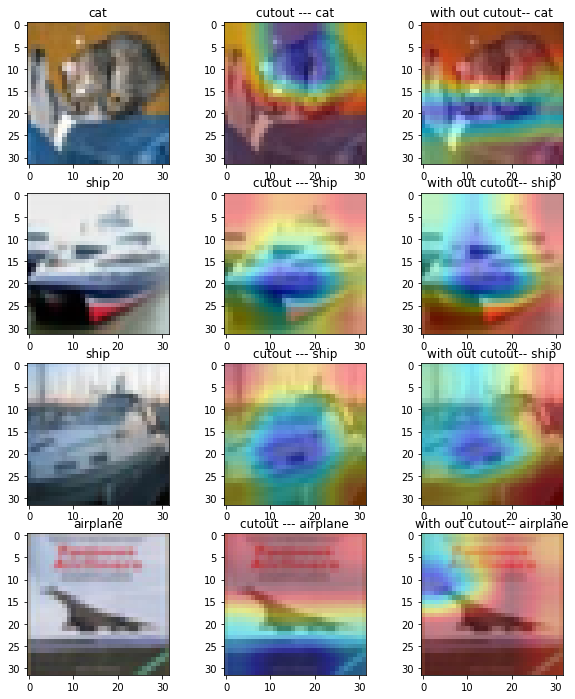

In [13]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
%matplotlib inline
fig, ax = plt.subplots(4,3,figsize=(10, 12))
for k,l in enumerate(test_features[:4]):
  
  superimposed_img_cutout, preds_cutout = grad_CAM_cutout(test_features[k])
  superimposed_img, preds = grad_CAM(test_features[k])
  
  ax[k,0].imshow(l)
  ax[k,0].set_title(str(class_names[test_labels[k][0]]))
  ax[k,1].imshow(superimposed_img_cutout)
  ax[k,1].set_title("cutout" +" --- " + str(class_names[np.argmax(preds_cutout)]))
  ax[k,2].imshow(superimposed_img)
  ax[k,2].set_title("with out cutout"+ "-- " + str(class_names[np.argmax(preds)]))
  